# Progressive Inference for Music Demixing ID: L12
Description: Using denoising diffusion approaches to train music demixing (MDX) models is
promising but requires retraining large and carefully tuned neural networks (Plaja-Roglans,
2022). Instead, we will explore a related yet different approach: can we improve separation
quality solely by scheduling the inference process using a diffusion-inspired strategy even
without retraining? By experimenting with existing MDX models (Spleeter by Deezer,Meta’s Demucs, ByteDance’s BS-Roformer, etc.), this project offers an exciting opportunity
to explore and possibly enhance the performance of state-of-the-art AI techniques.

**Resources**


(Plaja-Roglans, 2022) https://ismir2022program.ismir.net/poster_262.html
Denoising Diffusion Probabilistic Models: https://arxiv.org/abs/2006.11239
MDX Challenge 2021: https://arxiv.org/abs/2108.13559
MDX Challenge 2023: https://arxiv.org/abs/2308.06979
Overview of state-of-the-art MDX models:
https://paperswithcode.com/sota/music-source-separation-on-musdb18-hq

### Preliminary step: Install and Import Libraries.

In [1]:
%pip install -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
import torch
import torchaudio
import os
import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Audio
from mir_eval import separation
from torchaudio.pipelines import HDEMUCS_HIGH_MUSDB_PLUS
from torchaudio.transforms import Fade

### Load the Model

In [3]:
bundle = HDEMUCS_HIGH_MUSDB_PLUS
model = bundle.get_model()
sample_rate = bundle.sample_rate

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
model.to(device)

HDemucs(
  (freq_encoder): ModuleList(
    (0): _HEncLayer(
      (conv): Conv2d(4, 48, kernel_size=(8, 1), stride=(4, 1), padding=(2, 0))
      (norm1): Identity()
      (rewrite): Conv2d(48, 96, kernel_size=(1, 1), stride=(1, 1))
      (norm2): Identity()
      (dconv): _DConv(
        (layers): ModuleList(
          (0): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(1,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
            (4): GroupNorm(1, 96, eps=1e-05, affine=True)
            (5): GLU(dim=1)
            (6): _LayerScale()
          )
          (1): Sequential(
            (0): Conv1d(48, 12, kernel_size=(3,), stride=(1,), padding=(2,), dilation=(2,))
            (1): GroupNorm(1, 12, eps=1e-05, affine=True)
            (2): GELU(approximate='none')
            (3): Conv1d(12, 96, kernel_size=(1,), stride=(1,))
           

### Load the Dataset

Download the dataset at: https://zenodo.org/records/3338373

In [4]:
# Load dataset and choose the length of the tracks for each song (in seconds)
DATASET_FOLDER =  "./musdb18hq/test"
SEGMENT = 30  # We'll keep exactly 30 seconds from each track


track_folders = sorted(
    folder for folder in os.listdir(DATASET_FOLDER)
    if os.path.isdir(os.path.join(DATASET_FOLDER, folder))
)

# Dictionary to store {track_folder -> {stem_name -> waveform}}
dataset_dict = {}


# Each subfolder in musdb18hq/test corresponds to a track
for track_folder in track_folders:
    track_path = os.path.join(DATASET_FOLDER, track_folder)
    if not os.path.isdir(track_path):
        continue

    # Prepare a sub-dictionary for this track
    stems_dict = {}
    stem_names = ["mixture", "drums", "bass", "vocals", "other"]
    
    for stem_name in stem_names:
        file_path = os.path.abspath(os.path.join(track_path, f"{stem_name}.wav"))
        
        if not os.path.isfile(file_path):
            print(f"Warning: file not found {file_path}")
            continue

        # Load full audio
        print(f"Loading {file_path}...")
        waveform, sr = torchaudio.load(file_path)
        
        # Keep only the first 30s
        segment_samples = SEGMENT * sr
        waveform_segment = waveform[:, :segment_samples]

        stems_dict[stem_name] = waveform_segment

    dataset_dict[track_folder] = stems_dict

print("Loaded tracks:", list(dataset_dict.keys()))

Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/mixture.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/drums.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/bass.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/vocals.wav...
Loading /Users/filippo/Library/CloudStorage/OneDrive-PolitecnicodiMilano/Corsi/Music and Acoustic Engineering Capstone 🗝️/Git/DEMIXING/musdb18hq/test/AM Contra - Heart Peripheral/other.wav...
Loading /Users/filippo/Library/CloudSt

## Additional Functions

In [5]:
def find_non_silent_segment(stems: dict, segment_seconds: float, sample_rate: int, energy_threshold: float = 1e-4):
    """
    Finds a contiguous segment of seconds (segment_seconds) where every stem has non-silent audio.
    A segment is considered non-silent if for each stem the sum of the absolute amplitudes in each channel
    is greater than energy_threshold.

    Args:
        stems (dict): Dictionary mapping stem_name to waveform tensor of shape (channels, samples).
        segment_seconds (float): Desired segment duration in seconds.
        sample_rate (int): Sample rate to compute the segment length.
        energy_threshold (float): Minimal energy required per channel in the segment.
    
    Returns:
        dict or None: Dictionary with the same keys as stems but only containing the non-silent segment,
                      or None if no such segment is found.
    """
    segment_samples = int(segment_seconds * sample_rate)
    
    # use the first stem to determine the total length
    total_samples = next(iter(stems.values())).shape[1]
    
    # use a reasonable step to speed up search (e.g., 10% of segment_samples)
    step = max(1, segment_samples // 10)
    
    for start in range(0, total_samples - segment_samples + 1, step):
        valid = True
        # Check every stem for non-silence on all channels
        for waveform in stems.values():
            segment = waveform[:, start:start+segment_samples]
            energy = segment.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                valid = False
                break
        if valid:
            # If found, return a new dictionary with the non-silent segment for each stem.
            return {stem: waveform[:, start:start+segment_samples] for stem, waveform in stems.items()}
        
    return None

### Processing a Single Track

#### Choose a Track to Process
Try analyze different tracks by changing the index of ***track_names[index]***

In [6]:
# Now you have a dictionary with track_folder as the key,
# and a sub-dict with "mixture", "drums", "bass", "vocals", "other" waveforms
track_names = list(dataset_dict.keys())

track_chosen = track_names[25]
print("Chosen track name:", track_chosen)

stems_available = list(dataset_dict[track_chosen].keys())
print("Stems:", stems_available)  # e.g. ['mixture', 'drums', 'bass', 'vocals', 'other']

# Check duration
mixture_waveform = dataset_dict[track_chosen]["mixture"]
duration_seconds = mixture_waveform.shape[1] / sample_rate
print(f"Duration (seconds): {duration_seconds}")

# Ensure we have all 5 stems
if len(stems_available) < 5:
    print("Warning: Not all stems found. This track might be incomplete.")

Chosen track name: Mu - Too Bright
Stems: ['mixture', 'drums', 'bass', 'vocals', 'other']
Duration (seconds): 30.0


#### Prepare the Data for Separation

In [7]:
mixture_waveform = mixture_waveform.to(device)

In [8]:
def normalize_waveform(mixture_waveform: torch.Tensor, device: torch.device) -> torch.Tensor:
    """
    Normalize a waveform by moving it to the specified device, 
    and ensuring zero mean and unit variance across channels.

    Args:
        mixture_waveform (torch.Tensor): The input waveform tensor.
        device (torch.device): The device to move the waveform to.

    Returns:
        torch.Tensor: The normalized waveform.
        ref (torch.Tensor): The reference tensor used for normalization.
    """
    # Move waveform to the specified device
    mixture_waveform = mixture_waveform.to(device)

    # Normalization across the channels
    ref = mixture_waveform.mean(0)  # (2, samples) -> (samples,)

    # Signal with zero mean and unit variance
    mixture_norm = (mixture_waveform - ref.mean()) / ref.std()

    return mixture_norm, ref

In [9]:
# Normalize the mixture waveform and get the reference tensor
mixture_norm, ref = normalize_waveform(mixture_waveform, device)

In [10]:
def invert_normalization(normalized_waveform: torch.Tensor, reference: torch.Tensor) -> torch.Tensor:
    """
    Inverts the normalization on a waveform.
    Assumes normalization was done as:
       normalized = (waveform - reference.mean()) / reference.std()
       
    Args:
        normalized_waveform (torch.Tensor): The normalized waveform.
        reference (torch.Tensor): The original waveform used to compute normalization statistics.
        
    Returns:
        torch.Tensor: The waveform with the original scale restored.
    """
    return normalized_waveform * reference.std() + reference.mean()

In [11]:
def separate_sources(
    model,
    mix,
    segment=30,
    overlap=0.0,  # set to 0.0 to avoid chunk repetition
    device=None
):
    """
    Apply model to a given mixture. Use fade, and add segments together in order to add model segment by segment.

    Args:
        segment (int): segment length in seconds
        device (torch.device, str, or None): if provided, device on which to
            execute the computation, otherwise `mix.device` is assumed.
            When `device` is different from `mix.device`, only local computations will
            be on `device`, while the entire tracks will be stored on `mix.device`.
    """

    if device is None:
        device = mix.device
    else:
        device = torch.device(device)

    batch, channels, length = mix.shape

    # chunk_len for entire 30s, no overlap
    chunk_len = int(sample_rate * segment * (1 + overlap))  # effectively 30s if overlap=0
    start = 0
    end = chunk_len

    overlap_frames = int(overlap * sample_rate)
    fade = Fade(fade_in_len=0, fade_out_len=overlap_frames, fade_shape="linear")

    # Prepare final buffer
    final = torch.zeros(batch, len(model.sources), channels, length, device=device)

    while start < length - overlap_frames:
        chunk = mix[:, :, start:end]
        with torch.no_grad():
            out = model(chunk)
        out = fade(out)
        final[:, :, :, start:end] += out

        if start == 0:
            fade.fade_in_len = overlap_frames
            start += chunk_len - overlap_frames
        else:
            start += chunk_len
        end += chunk_len
        if end >= length:
            fade.fade_out_len = 0

    return final

#### Run Separation

In [12]:
print("Separating 30-second track with no overlap...")
import os

# Enable MPS fallback for unsupported operations
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"

# Ensure both the model and the input tensor are on the same device
model.to("cpu")
mixture_norm_cpu = mixture_norm[None].to("cpu")  # Move input tensor to CPU

sources_tensor = separate_sources(
    model,
    mixture_norm_cpu,  # Use the tensor on the CPU
    segment=30,
    overlap=0.0,
    device="cpu"  # Use CPU for this operation
)[0].to(device)  # Move back to MPS after the operation

# Move the model back to the original device (MPS)
model.to(device)

# Undo normalization
sources_tensor = sources_tensor * ref.std() + ref.mean()

# Build a dict {stem_name -> predicted_stem}
stem_names = model.sources  # ['drums', 'bass', 'other', 'vocals'] typically
predicted_stems = dict(zip(stem_names, list(sources_tensor)))


Separating 30-second track with no overlap...


#### Evaluations

In [13]:
def output_results(original_source: torch.Tensor, predicted_source: torch.Tensor, source: str, getOutput=False):
    # Move to CPU
    original_np = original_source.detach().cpu().numpy()
    predicted_np = predicted_source.detach().cpu().numpy()

    # If shape is (C, T), that's fine for mir_eval if C=2
    # but let's ensure it's (2, T) not (T, 2)
    # Usually PyTorch waveforms are (channels, samples),
    # which is correct for bss_eval_sources.

    # Verify the energy of the reference(sum of the absolutes for each channel).
    energy = original_source.abs().sum(dim=1)
    print(f"{source} - Energy per channel: {energy}")
    
    # If one of the cheannel has an energy below the energy threshold (1e-3), skip the evaluation
    if (energy < 1e-3).any():
        print(f"Warning: {source} reference appears silent or nearly silent. Skipping evaluation for this stem.")
        return None  # oppure ritorna un valore di default o una stringa informativa
    sdr, sir, sar, _ = separation.bss_eval_sources(
        reference_sources=original_np,
        estimated_sources=predicted_np
    )

    print(f"--- {source} ---")
    print("SDR:", sdr.mean())
    print("SIR:", sir.mean())
    print("SAR:", sar.mean())
    print("----------------")

    if getOutput:
        return Audio(predicted_source.cpu(), rate=sample_rate)

# Retrieve references from dataset_dict
drums_ref = dataset_dict[track_chosen]["drums"].to(device)
bass_ref = dataset_dict[track_chosen]["bass"].to(device)
vocals_ref = dataset_dict[track_chosen]["vocals"].to(device)
other_ref = dataset_dict[track_chosen]["other"].to(device)

# Predicted
drums_pred = predicted_stems["drums"]
bass_pred  = predicted_stems["bass"]
vocals_pred = predicted_stems["vocals"]
other_pred = predicted_stems["other"]

# Evaluate each stem
output_results(drums_ref, drums_pred, "Drums")
output_results(bass_ref, bass_pred, "Bass")
output_results(vocals_ref, vocals_pred, "Vocals")
output_results(other_ref, other_pred, "Other")

Drums - Energy per channel: tensor([33873.6250, 37868.5703], device='mps:0')


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_65859/265406633.py:19: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(


--- Drums ---
SDR: 18.217174566513556
SIR: 32.395181868754605
SAR: 18.390333566457947
----------------
Bass - Energy per channel: tensor([12980.2188, 12790.1113], device='mps:0')
--- Bass ---
SDR: 11.210318517719578
SIR: 33.54281600122741
SAR: 11.23787602306246
----------------
Vocals - Energy per channel: tensor([25457.0078, 25799.2461], device='mps:0')
--- Vocals ---
SDR: 13.662620232887914
SIR: 31.7564004116576
SAR: 13.733936897451358
----------------
Other - Energy per channel: tensor([29620.5078, 28936.1367], device='mps:0')
--- Other ---
SDR: 9.428652091420789
SIR: 31.41757293316304
SAR: 9.461064094425627
----------------


## Analyze SDR / gains 

Dimostrazione predittore Oracle:
- la somma delle tracce è uguale alla mixture originale
- la separazione di una mixture creata dalla somma delle tracce equamente pesate, dà risultati migliori in fase di estrazione per la traccia mixata con un guadagno maggiore

In [14]:
def create_new_mixture(track_name: str, gains: torch.Tensor, dataset_dict: dict) -> torch.Tensor:
    """
    Create a new mixture for a given track name and desired gains.

    Args:
        track_name (str): The name of the track to process.
        gains (torch.Tensor): Tensor containing the gain values for each stem.
        dataset_dict (dict): Dictionary containing the dataset with track stems.

    Returns:
        torch.Tensor: The newly generated mixture waveform.
    """
    if track_name not in dataset_dict:
        raise ValueError(f"Track '{track_name}' not found in the dataset_dict.")

    # Retrieve the original stems for the given track
    original_stems = dataset_dict[track_name]

    # Normalize the gains
    gains_normalized = gains / gains.sum()
    # Ensure gains are on the same device as the stems
    device = next(iter(original_stems.values())).device
    gains_normalized = gains_normalized.to(device)

    # Exclude the "mixture" key so gains are applied only to the individual stems 
    relevant_stems = [stem for stem in original_stems.keys() if stem != "mixture"]
    adjusted_stems = {
        stem: original_stems[stem] * gains_normalized[i]
        for i, stem in enumerate(relevant_stems)
    }

    # Generate the new mixture by initializing a zero tensor on the correct device
    new_mixture = torch.zeros_like(next(iter(adjusted_stems.values())))
    for tensor in adjusted_stems.values():
        new_mixture += tensor

    return new_mixture

In [15]:
#Tempo d'esecuzione su Mac di Filippo: 1:59 s

sdr_values = []

homogeneous_gains = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

for track in dataset_dict:
    # Check if the track has the "mixture" stem
    if "mixture" not in dataset_dict[track]:
        print(f"Track '{track}' missing 'mixture'. Skipping.")
        continue

    original_mix = dataset_dict[track]["mixture"]
    
    try:
        # Create homogeneous mix from the non-mixture stems
        homo_mix = create_new_mixture(track, homogeneous_gains, dataset_dict)
        
        # Convert to numpy arrays for evaluation
        original_np = original_mix.detach().cpu().numpy()
        homo_np = homo_mix.detach().cpu().numpy()

        # Calculate the difference between original and homogeneous
        difference = original_np - homo_np
        print("Difference: ", difference)

        # Check if the difference is zero
        if np.allclose(original_np, homo_np, atol=1e-8):  # Tolleranza personalizzabile
            print(f"Track '{track}': The difference is zero (arrays are equal within tolerance).")
        else:
            print(f"Track '{track}': The difference is non-zero (arrays are not equal).")
        
        
        # Compute SDR using mir_eval's bss_eval_sources
        sdr, sir, sar, _ = separation.bss_eval_sources(original_np, homo_np)
        mean_sdr = sdr.mean()
        sdr_values.append(mean_sdr)
        
        print(f"Track '{track}': SDR = {mean_sdr:.2f}")
    except Exception as e:
        print(f"Error processing track '{track}': {e}")

if sdr_values:
    overall_mean_sdr = sum(sdr_values)/len(sdr_values)
    print("\nMean SDR across all tracks:", overall_mean_sdr)
else:
    print("No SDR values calculated.")

Difference:  [[ 0.0000000e+00  0.0000000e+00  2.2888184e-05 ...  7.4081421e-03
   1.4198303e-02  1.5274048e-02]
 [ 0.0000000e+00 -4.5776367e-05  0.0000000e+00 ...  5.4641724e-02
   4.5600891e-02  3.8871765e-02]]
Track 'AM Contra - Heart Peripheral': The difference is non-zero (arrays are not equal).


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_65859/2981113728.py:35: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr, sir, sar, _ = separation.bss_eval_sources(original_np, homo_np)


Track 'AM Contra - Heart Peripheral': SDR = 68.80
Difference:  [[ 0.          0.          0.         ... -0.01331329 -0.01223755
   0.00404358]
 [ 0.          0.          0.         ... -0.20146942 -0.20874023
  -0.19940186]]
Track 'Al James - Schoolboy Facination': The difference is non-zero (arrays are not equal).
Track 'Al James - Schoolboy Facination': SDR = 66.01
Difference:  [[0.         0.         0.         ... 0.01639557 0.02204895 0.01435852]
 [0.         0.         0.         ... 0.06221771 0.08968353 0.10132599]]
Track 'Angels In Amplifiers - I'm Alright': The difference is non-zero (arrays are not equal).
Track 'Angels In Amplifiers - I'm Alright': SDR = 67.64
Difference:  [[0.         0.         0.         ... 0.02410889 0.02779388 0.03417969]
 [0.         0.         0.         ... 0.0188446  0.02182007 0.027771  ]]
Track 'Arise - Run Run Run': The difference is non-zero (arrays are not equal).
Track 'Arise - Run Run Run': SDR = 69.12
Difference:  [[ 1.5258789e-05 -1.2054

In [16]:
# Efficient evaluation of SDR using MPS
def evaluate_sdr(dataset_dict, gains, model, device, sample_rate, segment_length=30, energy_threshold=1e-4):
    
    # Find non-silent segments for each track
    non_silent_dataset_dict = {}
    for track, stems in dataset_dict.items():
        non_silent_segment = find_non_silent_segment(stems, segment_seconds=segment_length, sample_rate=sample_rate)
        if non_silent_segment is not None:
            non_silent_dataset_dict[track] = non_silent_segment 


    sdr_results = {}

    for track in tqdm.tqdm(non_silent_dataset_dict, desc="Evaluating SDR"):
        if track not in non_silent_dataset_dict:
            print(f"Track '{track}' not found in dataset_dict. Skipping...")
            continue

        # Retrieve the original stems
        stems = non_silent_dataset_dict[track]
        if any(stem not in stems for stem in ["drums", "bass", "vocals", "other"]):
            print(f"Track '{track}' is missing some stems. Skipping...")
            continue

        # Create a new mixture
        new_mix = create_new_mixture(track, gains, non_silent_dataset_dict)

        # Normalize the mixture
        mixture_norm, ref = normalize_waveform(new_mix, device)

        # Ci vuole: Assicurati che il tensore di input sia un torch.FloatTensor
        mixture_norm = mixture_norm.to(torch.float32)  # Converte il tensore di input a torch.FloatTensor

        # Ci vuole: Assicurati che il tensore sia sul dispositivo corretto (CPU o GPU)
        mixture_norm = mixture_norm.to(device)  # device dovrebbe essere 'cpu' o 'MPS' (a seconda della configurazione)

        # Ci vuole: Per i pesi del modello, assicurati che siano dello stesso tipo e dispositivo
        for param in model.parameters():
            param.data = param.data.to(torch.float32).to(device)

        # Ora chiamiamo la funzione separate_sources con i tensori e i pesi corretti
        sources_tensor = separate_sources(
            model,
            mixture_norm[None],  # Aggiungi la dimensione del batch
            segment=segment_length,
            overlap=0.0,        #Se non aggiungiamo i "Ci vuole:" non funziiona la funzione se si richiama più volte perché non si resetta il tensore
            device=device
        )[0]  # Rimuovi la dimensione del batch

        # Undo normalization
        sources_tensor = invert_normalization(sources_tensor, ref)

        # Map predicted sources to their names
        predicted_stems = dict(zip(model.sources, list(sources_tensor)))

        # Evaluate SDR for each stem
        sdr_values = {}
        for stem_name in ["drums", "bass", "vocals", "other"]:
            ref_stem = stems[stem_name].to(device)
            pred_stem = predicted_stems[stem_name]

            #print(f"Evaluating SDR for '{track}' - '{stem_name}'...")
            # Skip evaluation if energy is below the threshold
            energy = ref_stem.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                print(f"Skipping evaluation for '{track}' - '{stem_name}' due to low energy.")
                sdr_values[stem_name] = None
                continue
            
            # Compute SDR
            sdr = separation.bss_eval_sources(
                reference_sources=ref_stem.cpu().numpy(),
                estimated_sources=pred_stem.cpu().numpy()
            )[0].mean()
            sdr_values[stem_name] = sdr

        sdr_results[track] = sdr_values

    return sdr_results

Evaluating SDR:   0%|          | 0/34 [00:00<?, ?it/s]/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_65859/119259295.py:71: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr = separation.bss_eval_sources(
Evaluating SDR: 100%|██████████| 34/34 [05:46<00:00, 10.20s/it]


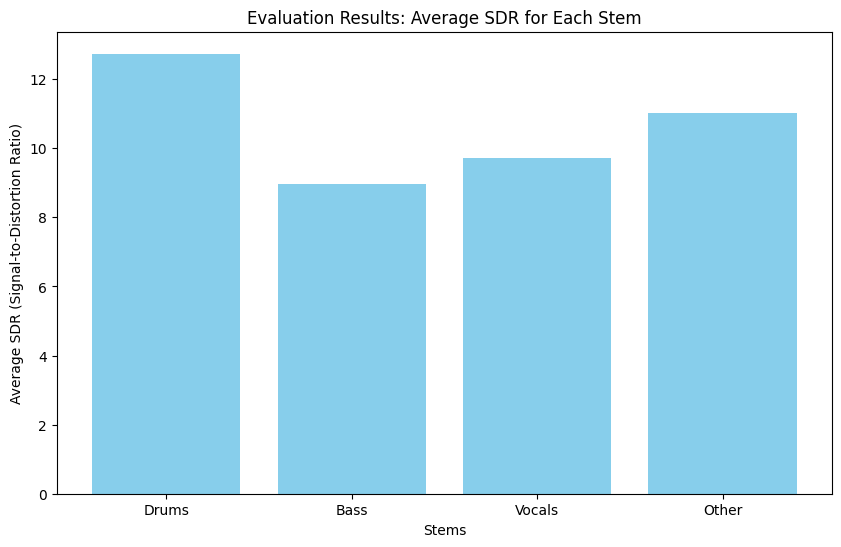

In [17]:
#Tempo d'esecuzione su Mac di Filippo: 1:59 s
uniform_gain = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

# Run the SDR evaluation
sdr_results = evaluate_sdr(dataset_dict, uniform_gain, model, device, sample_rate, segment_length=30)

# compute average SDR for each stem
sdr_averages = {
    "Drums": torch.tensor([v["drums"] for v in sdr_results.values() if v["drums"] is not None]).mean(),
    "Bass": torch.tensor([v["bass"] for v in sdr_results.values() if v["bass"] is not None]).mean(),
    "Vocals": torch.tensor([v["vocals"] for v in sdr_results.values() if v["vocals"] is not None]).mean(),
    "Other": torch.tensor([v["other"] for v in sdr_results.values() if v["other"] is not None]).mean()
}

# Plot the results
plt.figure(figsize=(10, 6))
stems_to_plot = list(sdr_averages.keys())
plt.bar(stems_to_plot, [sdr_averages[s] for s in stems_to_plot], color='skyblue')
plt.xlabel('Stems')
plt.ylabel('Average SDR (Signal-to-Distortion Ratio)')
plt.title('Evaluation Results: Average SDR for Each Stem')
plt.show()


Evaluating SDR:   0%|          | 0/34 [00:00<?, ?it/s]/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_65859/119259295.py:71: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  sdr = separation.bss_eval_sources(
Evaluating SDR: 100%|██████████| 34/34 [05:41<00:00, 10.05s/it]


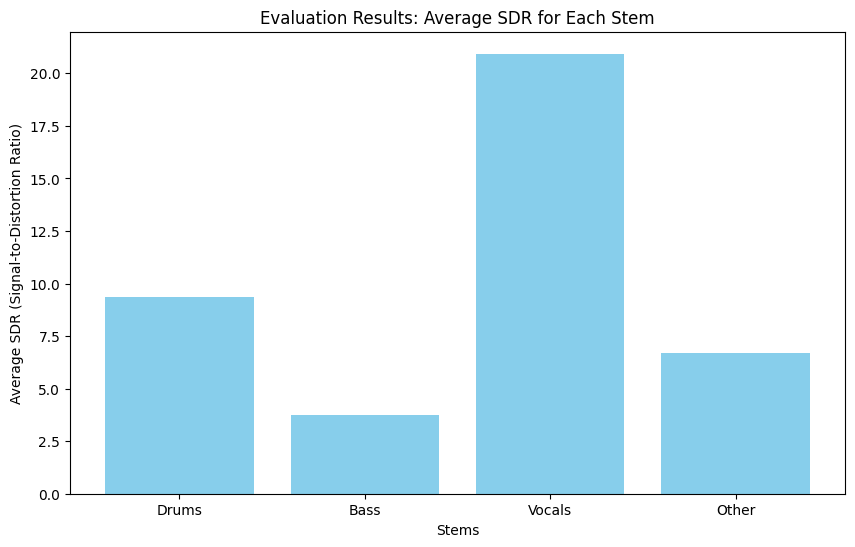

In [18]:
#Tempo d'esecuzione su Mac di Filippo: 5:30 s

biased_gains = torch.tensor([0.10, 0.10, 1, 0.10], device=device) #normalizzati dalla funzione evaluate_sdr: i gain sono chiamati come gain di un mixer

# Run the SDR evaluation
# Move the model to CPU for operations requiring unsupported MPS operators
#model_cpu = model.to("cpu")

# Run the SDR evaluation on CPU
sdr_results = evaluate_sdr(dataset_dict, biased_gains, model, device, sample_rate, segment_length=30)

# Move the model back to the original device (MPS)
model.to(device)

# compute average SDR for each stem
sdr_averages = {
    "Drums": torch.tensor([v["drums"] for v in sdr_results.values() if v["drums"] is not None]).mean(),
    "Bass": torch.tensor([v["bass"] for v in sdr_results.values() if v["bass"] is not None]).mean(),
    "Vocals": torch.tensor([v["vocals"] for v in sdr_results.values() if v["vocals"] is not None]).mean(),
    "Other": torch.tensor([v["other"] for v in sdr_results.values() if v["other"] is not None]).mean()
}

# Plot the results
plt.figure(figsize=(10, 6))
stems_to_plot = list(sdr_averages.keys())
plt.bar(stems_to_plot, [sdr_averages[s] for s in stems_to_plot], color='skyblue')
plt.xlabel('Stems')
plt.ylabel('Average SDR (Signal-to-Distortion Ratio)')
plt.title('Evaluation Results: Average SDR for Each Stem')
plt.show()

In [19]:
#def evaluate_sdr_with_dynamic_gains(dataset_dict, initial_gains, model, device, sample_rate, segment_length=30, energy_threshold=1e-4, steps=10, target_stem="vocals"):
    """
    Evaluate SDR with dynamic gain modification for a specific target stem.

    Parameters:
        dataset_dict (dict): Dataset containing tracks and stems.
        initial_gains (torch.Tensor): Initial gains for the stems (e.g., [0.25, 0.25, 0.25, 0.25]).
        model (torch.nn.Module): Separation model.
        device (str): Device to run the evaluation on.
        sample_rate (int): Sample rate of the audio.
        segment_length (int): Length of the audio segments in seconds.
        energy_threshold (float): Threshold to skip low-energy stems.
        steps (int): Number of steps to modify the gains.
        target_stem (str): The name of the stem to apply the target gain (e.g., "vocals").

    Returns:
        dict: SDR results for each track and gain configuration.
    """
    # Map stem names to indices
    stem_indices = {"drums": 0, "bass": 1, "vocals": 2, "other": 3}
    if target_stem not in stem_indices:
        raise ValueError(f"Invalid target stem '{target_stem}'. Must be one of {list(stem_indices.keys())}.")
    target_stem_idx = stem_indices[target_stem]

    # Find non-silent segments for each track
    non_silent_dataset_dict = {}
    for track, stems in dataset_dict.items():
        non_silent_segment = find_non_silent_segment(stems, segment_seconds=segment_length, sample_rate=sample_rate)
        if non_silent_segment is not None:
            non_silent_dataset_dict[track] = non_silent_segment 

    sdr_results = {}

    for track in tqdm.tqdm(non_silent_dataset_dict, desc=f"Evaluating SDR with Dynamic Gains for '{target_stem}'"):
        if track not in non_silent_dataset_dict:
            print(f"Track '{track}' not found in dataset_dict. Skipping...")
            continue

        # Retrieve the original stems
        stems = non_silent_dataset_dict[track]
        if any(stem not in stems for stem in ["drums", "bass", "vocals", "other"]):
            print(f"Track '{track}' is missing some stems. Skipping...")
            continue

        print(f"\nEvaluating SDR for track '{track}' with dynamic gains for '{target_stem}'...")
        
        for step in range(steps + 1):
            # Increase the gain of the target stem and decrease others proportionally
            target_gain = initial_gains[target_stem_idx] + (step * 0.05)  # Increment target stem gain
            remaining_gain = 1.0 - target_gain  # Remaining gain to distribute
            other_gains = [
                (remaining_gain * (initial_gains[i] / (1.0 - initial_gains[target_stem_idx])))
                if i != target_stem_idx else target_gain
                for i in range(4)
            ]
            modified_gains = torch.tensor(other_gains, device=device)

            # Create a new mixture with modified gains
            new_mix = create_new_mixture(track, modified_gains, non_silent_dataset_dict)

            # Normalize the mixture
            mixture_norm, ref = normalize_waveform(new_mix, device)

            # Ci vuole: Assicurati che il tensore di input sia un torch.FloatTensor
            mixture_norm = mixture_norm.to(torch.float32)  # Converte il tensore di input a torch.FloatTensor

            # Ci vuole: Assicurati che il tensore sia sul dispositivo corretto (CPU o GPU)
            mixture_norm = mixture_norm.to(device)  # device dovrebbe essere 'cpu' o 'MPS' (a seconda della configurazione)

            # Ci vuole: Per i pesi del modello, assicurati che siano dello stesso tipo e dispositivo
            for param in model.parameters():
                param.data = param.data.to(torch.float32).to(device)

            # Ora chiamiamo la funzione separate_sources con i tensori e i pesi corretti
            sources_tensor = separate_sources(
                model,
                mixture_norm[None],  # Aggiungi la dimensione del batch
                segment=segment_length,
                overlap=0.0,        #Se non aggiungiamo i "Ci vuole:" non funziiona la funzione se si richiama più volte perché non si resetta il tensore
                device=device
            )[0]  # Rimuovi la dimensione del batch

            # Undo normalization
            sources_tensor = invert_normalization(sources_tensor, ref)

            # Map predicted sources to their names
            predicted_stems = dict(zip(model.sources, list(sources_tensor)))

            # Evaluate SDR for the target stem
            ref_stem = stems[target_stem].to(device)
            pred_stem = predicted_stems[target_stem]

            # Skip evaluation if energy is below the threshold
            energy = ref_stem.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                print(f"Skipping evaluation for '{track}' - '{target_stem}' due to low energy.")
                continue

            # Compute SDR
            try:
                sdr = separation.bss_eval_sources(
                    reference_sources=ref_stem.cpu().numpy(),
                    estimated_sources=pred_stem.cpu().numpy()
                )[0].mean()
                print(f"SDR with gains {modified_gains.tolist()}: {sdr:.2f}")
            except Exception as e:
                print(f"Error computing SDR for track '{track}' with gains {modified_gains.tolist()}: {e}")

    return sdr_results

IndentationError: unexpected indent (524210304.py, line 2)

## Esperimento con Schedule

In [20]:
#Riscrivere come unica funzione
def constant_gain_test(current_gains):
    """
        current_gains (torch.Tensor): Current gains for the stems.
        step (int): Current step index.
        target_stem_idx (int): Index of the target stem.
        steps (int): Total number of steps.
        max_gain (float): Maximum gain for the target stem.
    """
    return current_gains


def linear_gain_schedule(current_gains, step, target_stem_idx, steps, max_gain=0.75):
    """
    Linearly increase the gain of the target stem and decrease others proportionally.

    Parameters:
        current_gains (torch.Tensor): Current gains for the stems.
        step (int): Current step index.
        target_stem_idx (int): Index of the target stem.
        steps (int): Total number of steps.
        max_gain (float): Maximum gain for the target stem.

    Returns:
        torch.Tensor: Updated gains.
    """
    # Calculate the target gain using a linear schedule
    target_gain = current_gains[target_stem_idx] + (max_gain - current_gains[target_stem_idx]) * (step / steps)

    # Distribute the remaining gain proportionally to the other stems
    remaining_gain = 1.0 - target_gain
    updated_gains = [
        (remaining_gain * (current_gains[i] / (1.0 - current_gains[target_stem_idx])))
        if i != target_stem_idx else target_gain
        for i in range(len(current_gains))
    ]
    return torch.tensor(updated_gains, device=current_gains.device)




def cosine_gain_schedule(current_gains, step, target_stem_idx, steps, max_gain=0.75):
    """
    Cosine schedule to modify the gains for the target stem.

    Parameters:
        current_gains (torch.Tensor): Current gains for the stems.
        step (int): Current step index.
        target_stem_idx (int): Index of the target stem.
        steps (int): Total number of steps.
        max_gain (float): Maximum gain for the target stem.

    Returns:
        torch.Tensor: Updated gains.
    """
    # Calculate the target gain using a cosine schedule
    target_gain = current_gains[target_stem_idx] + (max_gain - current_gains[target_stem_idx]) * (1 - math.cos(math.pi * step / steps)) / 2

    # Distribute the remaining gain proportionally to the other stems
    remaining_gain = 1.0 - target_gain
    updated_gains = [
        (remaining_gain * (current_gains[i] / (1.0 - current_gains[target_stem_idx])))
        if i != target_stem_idx else target_gain
        for i in range(len(current_gains))
    ]
    return torch.tensor(updated_gains, device=current_gains.device)


def exponential_schedule(t, T, sigma_max, sigma_min):
    """
    Applies an exponential decay schedule:
    sigma(t) = sigma_max * (sigma_min/sigma_max)^(t/T)
    """
    return sigma_max * ((sigma_min / sigma_max) ** (t / T))

def logarithmic_schedule(t, T, sigma_max, sigma_min):
    """
    Uses a logarithmic schedule:
    sigma(t) = sigma_max - (sigma_max - sigma_min) * (log(t+1) / log(T+1))
    """
    return sigma_max - (sigma_max - sigma_min) * (math.log(t + 1) / math.log(T + 1))

def gain_schedule(t, T, gain_max, gain_min):
    """
    Restituisce un gain che decresce linearmente da gain_max a gain_min.
    
    Args:
        t (int): lo step corrente.
        T (int): il numero totale di step.
        gain_max (float): valore massimo (iniziale) del guadagno.
        gain_min (float): valore minimo (finale) del guadagno.
    
    Returns:
        float: il gain calcolato per lo step t.
    """
    return gain_max - (gain_max - gain_min) * (t / T)

In [21]:
dataset_dict[track]["mixture"]


tensor([[ 0.0164,  0.0228,  0.0283,  ...,  0.0706,  0.0452,  0.0607],
        [-0.0368, -0.0453, -0.0523,  ...,  0.0230,  0.0005,  0.0137]])

In [22]:
def evaluate_sdr_with_dynamic_gains_single_track(
    track, stems, initial_gains, model, device, sample_rate, segment_length=30, 
    energy_threshold=1e-4, steps=10, gain_schedule=None
):
    """
    Evaluate SDR with dynamic gain modification for a single track.

    Parameters:
        track (str): Name of the track.
        stems (dict): Dictionary containing the stems for the track.
        initial_gains (torch.Tensor): Initial gains for the stems (e.g., [0.25, 0.25, 0.25, 0.25]).
        model (torch.nn.Module): Separation model.
        device (str): Device to run the evaluation on.
        sample_rate (int): Sample rate of the audio.
        segment_length (int): Length of the audio segments in seconds.
        energy_threshold (float): Threshold to skip low-energy stems.
        steps (int): Number of steps to modify the gains.
        gain_schedule (callable): Function to modify the gains at each step. 
                                  It should accept the current gains and step index, and return updated gains.

    Returns:
        dict: SDR results for each stem.
    """

    # Map stem names to indices
    stem_indices = {"drums": 0, "bass": 1, "vocals": 2, "other": 3}
    sdr_results = {}

    # Ensure all required stems are present
    if any(stem not in stems for stem in stem_indices.keys()):
        raise ValueError(f"Track '{track}' is missing some stems. Cannot evaluate SDR.")

    print(f"\nEvaluating SDR for track '{track}'...")

    for target_stem, target_stem_idx in stem_indices.items():
        print(f"\nProcessing target stem: '{target_stem}'")

        # Store initial SDR
        ref_stem = stems[target_stem].to(device)
        energy = ref_stem.abs().sum(dim=1)
        if (energy < energy_threshold).any():
            print(f"Skipping evaluation for '{track}' - '{target_stem}' due to low energy.")
            continue

        # Create initial mixture and compute SDR
        # create a tensor called initial_mix to store the original mixture contained in the directory of the dataset
        initial_mix = dataset_dict[track]["mixture"].to(device)
        #initial_mix = create_new_mixture(track, initial_gains, {track: stems}) #Funzione sbagliata perché crea il mix e non prende l'originale
        mixture_norm, ref = normalize_waveform(initial_mix, device)
        sources_tensor = separate_sources(
            model,
            mixture_norm[None],  # Add batch dimension
            segment=segment_length,
            overlap=0.0,
            device=device
        )[0]  # Remove batch dimension
        sources_tensor = invert_normalization(sources_tensor, ref)
        predicted_stems = dict(zip(model.sources, list(sources_tensor)))
        pred_stem = predicted_stems[target_stem]

        try:
            initial_sdr = separation.bss_eval_sources(
                reference_sources=ref_stem.cpu().numpy(),
                estimated_sources=pred_stem.cpu().numpy()
            )[0].mean()
            print(f"Initial SDR for '{target_stem}': {initial_sdr:.2f}")
        except Exception as e:
            print(f"Error computing initial SDR for '{target_stem}': {e}")
            continue

        # Perform dynamic gain modification with tqdm
        current_gains = initial_gains.clone()
        for step in tqdm(range(steps + 1), desc=f"Processing '{target_stem}'", leave=True):
            # Update gains using the schedule function if provided
            if gain_schedule is not None:
                current_gains = gain_schedule(current_gains, step, target_stem_idx)

            # Create a new mixture with modified gains
            new_mix = create_new_mixture(track, current_gains, {track: stems})

            # Normalize the mixture
            mixture_norm, ref = normalize_waveform(new_mix, device)

            # Separate sources
            sources_tensor = separate_sources(
                model,
                mixture_norm[None],  # Add batch dimension
                segment=segment_length,
                overlap=0.0,
                device=device
            )[0]  # Remove batch dimension

            # Undo normalization
            sources_tensor = invert_normalization(sources_tensor, ref)

            # Map predicted sources to their names
            predicted_stems = dict(zip(model.sources, list(sources_tensor)))

            # Evaluate SDR for the target stem
            pred_stem = predicted_stems[target_stem]

            # Skip evaluation if energy is below the threshold
            energy = ref_stem.abs().sum(dim=1)
            if (energy < energy_threshold).any():
                print(f"Skipping evaluation for '{track}' - '{target_stem}' due to low energy.")
                continue

            # Compute SDR
            if step == steps:
                try:
                    final_sdr = separation.bss_eval_sources(
                        reference_sources=ref_stem.cpu().numpy(),
                        estimated_sources=pred_stem.cpu().numpy()
                    )[0].mean()
                    sdr_results[target_stem] = {"initial_sdr": initial_sdr, "final_sdr": final_sdr}
                except Exception as e:
                    print(f"Error computing SDR for '{track}' with gains {current_gains.tolist()}: {e}")

    return sdr_results


In [23]:
track_names = list(dataset_dict.keys())
track_chosen = track_names[30]
stems = dataset_dict[track_chosen]
initial_gains = torch.tensor([0.25, 0.25, 0.25, 0.25], device=device)

# Move the model to CPU for operations requiring unsupported MPS operators
model_cpu = model.to("cpu")

# Run the SDR evaluation on CPU
# sdr_results = evaluate_sdr_with_dynamic_gains_single_track(
#     track=track_chosen,
#     stems=stems,
#     initial_gains=initial_gains,
#     model=model_cpu,
#     device="cpu",  # Use CPU for this operation
#     sample_rate=sample_rate,
#     segment_length=30,
#     energy_threshold=1e-4,
#     steps=10,
#     gain_schedule=lambda current_gains, step, target_stem_idx: cosine_gain_schedule(
#         current_gains, step, target_stem_idx, steps=10, max_gain=0.75
#     )
# )

sdr_results = evaluate_sdr_with_dynamic_gains_single_track(
    track=track_chosen,
    stems=stems,
    initial_gains=initial_gains,
    model=model_cpu,
    device="cpu",  # Use CPU for this operation
    sample_rate=sample_rate,
    segment_length=30,
    energy_threshold=1e-4,
    steps=10,
    gain_schedule=lambda current_gains, step, target_stem_idx: constant_gain_test(current_gains)
)

# Move the model back to the original device (MPS)
model.to(device)

print("\nSDR Results:")
for stem, results in sdr_results.items():
    print(f"{stem.capitalize()}: Initial SDR = {results['initial_sdr']:.2f}, Final SDR = {results['final_sdr']:.2f}")


# Extract data for plotting
stems = list(sdr_results.keys())
initial_sdrs = [sdr_results[stem]["initial_sdr"] for stem in stems]
final_sdrs = [sdr_results[stem]["final_sdr"] for stem in stems]

# Plotting
x = range(len(stems))  # X positions for the stems
width = 0.35  # Width of the bars

fig, ax = plt.subplots(figsize=(10, 6))

# Plot initial SDRs
ax.bar([pos - width / 2 for pos in x], initial_sdrs, width, label="Initial SDR", color="skyblue")

# Plot final SDRs
ax.bar([pos + width / 2 for pos in x], final_sdrs, width, label="Final SDR", color="orange")

# Add labels, title, and legend
ax.set_xlabel("Stems")
ax.set_ylabel("SDR (dB)")
ax.set_title("Initial vs Final SDR for Each Stem for Track: " + track_chosen)
ax.set_xticks(x)
ax.set_xticklabels([stem.capitalize() for stem in stems])
ax.legend()

# Show the plot
plt.tight_layout()
plt.show()


Evaluating SDR for track 'Raft Monk - Tiring'...

Processing target stem: 'drums'


/var/folders/1y/qqxfq_4d3bv6t32r2gml_0qh0000gn/T/ipykernel_65859/1902503112.py:62: FutureWarning: mir_eval.separation.bss_eval_sources
	Deprecated as of mir_eval version 0.8.
	It will be removed in mir_eval version 0.9.
  initial_sdr = separation.bss_eval_sources(


Initial SDR for 'drums': 7.14


TypeError: 'module' object is not callable